## Imports

Below are the libraries and modules used in this project, including libraries for image processing (`PIL`), deep learning (`torch` and `torchvision`), and utilities like `tqdm` for progress bars and `mlflow` for tracking experiments.


In [15]:
import sys
print(sys.path)
import sys
import os
sys.path.append(os.path.abspath('../src'))


['/home/cs2r/Desktop/Real-Time-Driver-Drowsiness-Detection-main/notebooks', '/home/cs2r/anaconda3/lib/python312.zip', '/home/cs2r/anaconda3/lib/python3.12', '/home/cs2r/anaconda3/lib/python3.12/lib-dynload', '', '/home/cs2r/anaconda3/lib/python3.12/site-packages', '/home/cs2r/anaconda3/lib/python3.12/site-packages/setuptools/_vendor', '/home/cs2r/Desktop/Real-Time-Driver-Drowsiness-Detection-main/src', '/tmp/tmpsncpsxsz']


In [16]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import torch.multiprocessing as mp
from models.cnn_model import Custom_CNN
from models.train import training
from torchsummary import summary
from torchvision.utils import make_grid
from utils.utils import display_images
import torchvision

### Device Setup

Determines the appropriate device for PyTorch operations. The device is chosen based on the availability of CUDA (NVIDIA GPUs) or MPS (Apple Silicon GPUs).
If neither is available, it defaults to the CPU.



In [17]:
device = (
    "cuda" if torch.cuda.is_available()
    
    # else "mps" if torch.backends.mps.is_available() 
    
    else "cpu"
)

device

'cuda'

# Data Augmentation & Transforms

In [18]:

train_transforms = transforms.Compose([
    transforms.Resize(size=(128, 128)),
   
    
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(128, 128)),
   
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5])
])

#  Load Dataset

In [39]:
dataset_path = "../datasets/Mouth_Dataset"
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'val'), transform=test_transforms)
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'test'), transform=test_transforms)


class_idx = train_dataset.class_to_idx
print(f"Index of classes are: {class_idx}")

class_names = list(class_idx)
print(f"\nClass Names are: {class_names}")


Index of classes are: {'No_Yawn': 0, 'Yawn': 1}

Class Names are: ['No_Yawn', 'Yawn']


# Create DataLoaders


In [40]:
BATCH_SIZE = 32
NUM_WORKERS = min(4, os.cpu_count())


train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    persistent_workers=True,
    pin_memory=True if device == "cuda" else False
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    persistent_workers=True,
    pin_memory=True if device == "cuda" else False
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    persistent_workers=True,
    pin_memory=True if device == "cuda" else False
)

# Visualizes

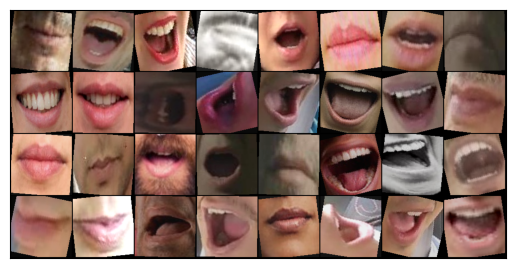

In [21]:
example_img = next(iter(train_dataloader))[0]
img_grid = make_grid(example_img)
display_images(img_grid)


# Initialize Model

In [22]:

model = Custom_CNN(
    input_shape=3,
    hidden_units=10, 
    output_shape=len(train_dataset.classes)
).to(device)
summary(model, input_size=(3, 128, 128), device=device)

# model_name = "efficientnet_b0"
# model = torchvision.models.efficientnet_b0(weights="DEFAULT")

# model.features[0][0]=nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

# model.classifier[1]=nn.Linear(in_features=1280, out_features=2, bias=True)
# model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 128, 128]             280
       BatchNorm2d-2         [-1, 10, 128, 128]              20
              ReLU-3         [-1, 10, 128, 128]               0
            Conv2d-4         [-1, 10, 128, 128]             910
       BatchNorm2d-5         [-1, 10, 128, 128]              20
              ReLU-6         [-1, 10, 128, 128]               0
         MaxPool2d-7           [-1, 10, 64, 64]               0
            Conv2d-8           [-1, 20, 64, 64]           1,820
       BatchNorm2d-9           [-1, 20, 64, 64]              40
             ReLU-10           [-1, 20, 64, 64]               0
           Conv2d-11           [-1, 20, 64, 64]           3,620
      BatchNorm2d-12           [-1, 20, 64, 64]              40
             ReLU-13           [-1, 20, 64, 64]               0
        MaxPool2d-14           [-1, 20,

# Training Configuration

In [23]:

EPOCHS = 150
LEARNING_RATE = 1e-3  

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Train the model

In [24]:

try:
    results = training(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=EPOCHS,
        device=device,
        scheduler=scheduler,
        early_stopping_patience=25,
        experiment_name="MouthClassifier_v2"
    )
except KeyboardInterrupt:
    print("\033[33m Training interrupted by user!")
finally:
    # Cleanup
    for dataloader in [train_dataloader, val_dataloader, test_dataloader]:
        if hasattr(dataloader, '_iterator') and dataloader._iterator is not None:
            dataloader._iterator._shutdown_workers()

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 00 | Train Loss: 0.2735 | Train Acc: 0.8891 | Val Loss: 0.2064 | Val Acc: 0.9319 | LR: 0.001000
 Saved best model with accuracy: 0.9319


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 01 | Train Loss: 0.1724 | Train Acc: 0.9395 | Val Loss: 0.1159 | Val Acc: 0.9678 | LR: 0.001000
 Saved best model with accuracy: 0.9678


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 02 | Train Loss: 0.1329 | Train Acc: 0.9553 | Val Loss: 0.1009 | Val Acc: 0.9594 | LR: 0.001000


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 03 | Train Loss: 0.1361 | Train Acc: 0.9587 | Val Loss: 0.0977 | Val Acc: 0.9692 | LR: 0.000999
 Saved best model with accuracy: 0.9692


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 04 | Train Loss: 0.1547 | Train Acc: 0.9451 | Val Loss: 0.1170 | Val Acc: 0.9543 | LR: 0.000998


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 05 | Train Loss: 0.0996 | Train Acc: 0.9657 | Val Loss: 0.1053 | Val Acc: 0.9632 | LR: 0.000997


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 06 | Train Loss: 0.0927 | Train Acc: 0.9710 | Val Loss: 0.0653 | Val Acc: 0.9781 | LR: 0.000996
 Saved best model with accuracy: 0.9781


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 07 | Train Loss: 0.0827 | Train Acc: 0.9727 | Val Loss: 0.1156 | Val Acc: 0.9603 | LR: 0.000995


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 08 | Train Loss: 0.0828 | Train Acc: 0.9719 | Val Loss: 0.0671 | Val Acc: 0.9748 | LR: 0.000993


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 09 | Train Loss: 0.0782 | Train Acc: 0.9743 | Val Loss: 0.0524 | Val Acc: 0.9785 | LR: 0.000991
 Saved best model with accuracy: 0.9785


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 10 | Train Loss: 0.0741 | Train Acc: 0.9760 | Val Loss: 0.0535 | Val Acc: 0.9795 | LR: 0.000989
 Saved best model with accuracy: 0.9795


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 11 | Train Loss: 0.0724 | Train Acc: 0.9746 | Val Loss: 0.0596 | Val Acc: 0.9813 | LR: 0.000987
 Saved best model with accuracy: 0.9813


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 12 | Train Loss: 0.1087 | Train Acc: 0.9632 | Val Loss: 0.1770 | Val Acc: 0.9482 | LR: 0.000984


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 13 | Train Loss: 0.0794 | Train Acc: 0.9725 | Val Loss: 0.0506 | Val Acc: 0.9837 | LR: 0.000982
 Saved best model with accuracy: 0.9837


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 14 | Train Loss: 0.0686 | Train Acc: 0.9773 | Val Loss: 0.0463 | Val Acc: 0.9851 | LR: 0.000979
 Saved best model with accuracy: 0.9851


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 15 | Train Loss: 0.0649 | Train Acc: 0.9772 | Val Loss: 0.0499 | Val Acc: 0.9823 | LR: 0.000976


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 16 | Train Loss: 0.0620 | Train Acc: 0.9797 | Val Loss: 0.0754 | Val Acc: 0.9720 | LR: 0.000972


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 17 | Train Loss: 0.0791 | Train Acc: 0.9727 | Val Loss: 0.0428 | Val Acc: 0.9846 | LR: 0.000969


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 18 | Train Loss: 0.0587 | Train Acc: 0.9820 | Val Loss: 0.0524 | Val Acc: 0.9795 | LR: 0.000965


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 19 | Train Loss: 0.0618 | Train Acc: 0.9805 | Val Loss: 0.0440 | Val Acc: 0.9846 | LR: 0.000961


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 20 | Train Loss: 0.0553 | Train Acc: 0.9831 | Val Loss: 0.0415 | Val Acc: 0.9888 | LR: 0.000957
 Saved best model with accuracy: 0.9888


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 21 | Train Loss: 0.0480 | Train Acc: 0.9847 | Val Loss: 0.0418 | Val Acc: 0.9869 | LR: 0.000952


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 22 | Train Loss: 0.0542 | Train Acc: 0.9824 | Val Loss: 0.0606 | Val Acc: 0.9785 | LR: 0.000948


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 23 | Train Loss: 0.0561 | Train Acc: 0.9809 | Val Loss: 0.0453 | Val Acc: 0.9851 | LR: 0.000943


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 24 | Train Loss: 0.0497 | Train Acc: 0.9843 | Val Loss: 0.0466 | Val Acc: 0.9809 | LR: 0.000938


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 25 | Train Loss: 0.0511 | Train Acc: 0.9837 | Val Loss: 0.0599 | Val Acc: 0.9813 | LR: 0.000933


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 26 | Train Loss: 0.0488 | Train Acc: 0.9851 | Val Loss: 0.0343 | Val Acc: 0.9902 | LR: 0.000928
 Saved best model with accuracy: 0.9902


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 27 | Train Loss: 0.0476 | Train Acc: 0.9859 | Val Loss: 0.0350 | Val Acc: 0.9865 | LR: 0.000922


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 28 | Train Loss: 0.0451 | Train Acc: 0.9853 | Val Loss: 0.0359 | Val Acc: 0.9893 | LR: 0.000916


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 29 | Train Loss: 0.0430 | Train Acc: 0.9856 | Val Loss: 0.0988 | Val Acc: 0.9729 | LR: 0.000911


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 30 | Train Loss: 0.0410 | Train Acc: 0.9872 | Val Loss: 0.0430 | Val Acc: 0.9851 | LR: 0.000905


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 31 | Train Loss: 0.0406 | Train Acc: 0.9868 | Val Loss: 0.0317 | Val Acc: 0.9893 | LR: 0.000898


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 32 | Train Loss: 0.0396 | Train Acc: 0.9878 | Val Loss: 0.0354 | Val Acc: 0.9883 | LR: 0.000892


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 33 | Train Loss: 0.0437 | Train Acc: 0.9848 | Val Loss: 0.0625 | Val Acc: 0.9813 | LR: 0.000885


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 34 | Train Loss: 0.0380 | Train Acc: 0.9883 | Val Loss: 0.0429 | Val Acc: 0.9879 | LR: 0.000878


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 35 | Train Loss: 0.0397 | Train Acc: 0.9867 | Val Loss: 0.0463 | Val Acc: 0.9860 | LR: 0.000872


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 36 | Train Loss: 0.0340 | Train Acc: 0.9897 | Val Loss: 0.0398 | Val Acc: 0.9855 | LR: 0.000864


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 37 | Train Loss: 0.0375 | Train Acc: 0.9890 | Val Loss: 0.0369 | Val Acc: 0.9879 | LR: 0.000857


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 38 | Train Loss: 0.0313 | Train Acc: 0.9901 | Val Loss: 0.0356 | Val Acc: 0.9911 | LR: 0.000850
 Saved best model with accuracy: 0.9911


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 39 | Train Loss: 0.0384 | Train Acc: 0.9878 | Val Loss: 0.0343 | Val Acc: 0.9907 | LR: 0.000842


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 40 | Train Loss: 0.0603 | Train Acc: 0.9852 | Val Loss: 0.0423 | Val Acc: 0.9851 | LR: 0.000835


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 41 | Train Loss: 0.0665 | Train Acc: 0.9774 | Val Loss: 0.0373 | Val Acc: 0.9893 | LR: 0.000827


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 42 | Train Loss: 0.0413 | Train Acc: 0.9874 | Val Loss: 0.0464 | Val Acc: 0.9855 | LR: 0.000819


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 43 | Train Loss: 0.0355 | Train Acc: 0.9883 | Val Loss: 0.0385 | Val Acc: 0.9893 | LR: 0.000811


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 44 | Train Loss: 0.0321 | Train Acc: 0.9902 | Val Loss: 0.0275 | Val Acc: 0.9911 | LR: 0.000802


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 45 | Train Loss: 0.0291 | Train Acc: 0.9914 | Val Loss: 0.0322 | Val Acc: 0.9907 | LR: 0.000794


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 46 | Train Loss: 0.0287 | Train Acc: 0.9915 | Val Loss: 0.0352 | Val Acc: 0.9893 | LR: 0.000785


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 47 | Train Loss: 0.0289 | Train Acc: 0.9916 | Val Loss: 0.0279 | Val Acc: 0.9902 | LR: 0.000777


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 48 | Train Loss: 0.0269 | Train Acc: 0.9916 | Val Loss: 0.0551 | Val Acc: 0.9785 | LR: 0.000768


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 49 | Train Loss: 0.0282 | Train Acc: 0.9915 | Val Loss: 0.0316 | Val Acc: 0.9883 | LR: 0.000759


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 50 | Train Loss: 0.0269 | Train Acc: 0.9919 | Val Loss: 0.0383 | Val Acc: 0.9879 | LR: 0.000750


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 51 | Train Loss: 0.0277 | Train Acc: 0.9904 | Val Loss: 0.0386 | Val Acc: 0.9888 | LR: 0.000741


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 52 | Train Loss: 0.0306 | Train Acc: 0.9905 | Val Loss: 0.0276 | Val Acc: 0.9911 | LR: 0.000732


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 53 | Train Loss: 0.0227 | Train Acc: 0.9928 | Val Loss: 0.0271 | Val Acc: 0.9907 | LR: 0.000722


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 54 | Train Loss: 0.0258 | Train Acc: 0.9920 | Val Loss: 0.0314 | Val Acc: 0.9902 | LR: 0.000713


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 55 | Train Loss: 0.0230 | Train Acc: 0.9929 | Val Loss: 0.0374 | Val Acc: 0.9888 | LR: 0.000703


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 56 | Train Loss: 0.0254 | Train Acc: 0.9912 | Val Loss: 0.0670 | Val Acc: 0.9748 | LR: 0.000694


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 57 | Train Loss: 0.0228 | Train Acc: 0.9927 | Val Loss: 0.0457 | Val Acc: 0.9869 | LR: 0.000684


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 58 | Train Loss: 0.0205 | Train Acc: 0.9942 | Val Loss: 0.0378 | Val Acc: 0.9888 | LR: 0.000674


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 59 | Train Loss: 0.0235 | Train Acc: 0.9927 | Val Loss: 0.0257 | Val Acc: 0.9911 | LR: 0.000664


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 60 | Train Loss: 0.0216 | Train Acc: 0.9931 | Val Loss: 0.0332 | Val Acc: 0.9888 | LR: 0.000655


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 61 | Train Loss: 0.0190 | Train Acc: 0.9943 | Val Loss: 0.0257 | Val Acc: 0.9911 | LR: 0.000645


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 62 | Train Loss: 0.0255 | Train Acc: 0.9924 | Val Loss: 0.0289 | Val Acc: 0.9907 | LR: 0.000634


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

 
Epoch: 63 | Train Loss: 0.0181 | Train Acc: 0.9943 | Val Loss: 0.0363 | Val Acc: 0.9897 | LR: 0.000624

Early stopping triggered after 64 epochs
 Loaded best model with accuracy: 0.9911
 Running final evaluation on test set...


Testing:   0%|          | 0/67 [00:00<?, ?it/s]

 Final Test Loss: 0.0649
 Final Test Accuracy: 0.9804
